In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score
from RBFlib import RBF
from shapely import points, Polygon

In [2]:
def loocv(x, y, model):
    warnings.filterwarnings("ignore")
    """х - массив точек.
    у - массив значений.
    возвращаяет R2 LOOCV модели"""
    pred = []
    loo = LeaveOneOut()
    if type(x) is not np.array:
        x = np.array(x)
    if type(y) is not np.array:
        y = np.array(y)
    for i, (train_index, test_index) in enumerate(loo.split(x)):
        model.fit(x[train_index], y[train_index])
        res = model.predict(np.array(x[test_index]))
        pred.append(float(res))
    return r2_score(y, pred)

In [3]:
def normalize(mas, coef):
    '''Возвращает нормализированный массив от 0 до 1, умноженный на коэффициент coef'''
    mas=np.array(mas)
    mas_min = mas.min()
    mas_max = mas.max()
    if mas_max - mas_min == 0:
        mas_norm = np.zeros_like(mas)  
    else:
        mas_norm = coef*(mas - mas_min) / (mas_max - mas_min)
    return mas_norm

def denormalize(mas_norm, min,max, coef):
    '''Возвращает ДЕнормализированный массив, mas_norm - нормализированный от 0 до 1 и умноженный на коэффициент coef'''
    mas_norm=np.array(mas_norm)/coef

    if max - min == 0:
        return np.full_like(mas_norm, min)
    else:
        mas_denorm = min + mas_norm * (max - min)
        return mas_denorm

In [4]:
def calc_surface(
    data: dict,
    coordinates: dict,
    resolution=100,
    model=RBF(),
    validation=False,
    normalize=True,
    gap=10,
):
    """
    Создает интерполированную карту значений на основе заданных данных и координат.
    Функция использует машинное обучение для интерполяции значений между известными точками
    и генерирует регулярную сетку значений, которая может быть использована для визуализации
    карты изолиний, тепловой карты или других типов пространственного анализа.
    Параметры:
    -----------
    data : dict
        Словарь, где ключи - идентификаторы точек, значения - числовые значения в этих точках
    coordinates : dict
        Словарь, где ключи - те же идентификаторы точек, значения - кортежи координат (x, y)
    resolution : int, optional, default=100
        Разрешение выходной сетки (количество точек по каждой оси)
    model : sklearn estimator, optional, default=RBF()
        Модель машинного обучения для интерполяции значений
    normalize : bool, optional, default=True
        Флаг нормализации координат перед обучением модели
    gap : int, optional, default=10
        Процент расширения границ карты относительно крайних точек (для отступа)

    Возвращает:
    -----------

    aa : numpy.ndarray
        2D массив координат X сетки (meshgrid)
    bb : numpy.ndarray
        2D массив координат Y сетки (meshgrid)
    z_map : numpy.ndarray
        2D массив интерполированных значений Z, соответствующих координатам сетки

    Пример использования:
    --------------------

    >>> data = {'point1': 10, 'point2': 20, 'point3': 15}

    >>> coordinates = {'point1': (0, 0), 'point2': (10, 10), 'point3': (5, 3)}

    >>> xx, yy, zz = calc_surface(data, coordinates, resolution=50)

    """

    X = np.array(
        list(coordinates.values())
    )  # X- массив координат [[x1.y1].[x2.y2]...]       

    x, y = X.T[0], X.T[1]  # координаты X и Y отдельно

    bounds_x = [min(x), max(x)]
    bounds_y = [min(y), max(y)]
    delta_x = (bounds_x[1] - bounds_x[0]) * gap / 100
    delta_y = (bounds_y[1] - bounds_y[0]) * gap / 100

    resolution = int(resolution)

    aa, bb = np.meshgrid(
        np.linspace(bounds_x[0] - delta_x, bounds_x[1] + delta_x, resolution),
        np.linspace(bounds_y[0] - delta_y, bounds_y[1] + delta_y, resolution),
    )

    xx = np.vstack([aa.ravel(), bb.ravel()]).T

    if normalize:
        scaler = StandardScaler()
        learn_X = scaler.fit_transform(np.array(list(coordinates.values())))
        pred_xx = scaler.fit_transform(xx)

    else:
        learn_X = X
        pred_xx = xx

    learn_Z = np.array(list(data.values())).reshape(-1, 1)  # массив значений
    model.fit(learn_X, learn_Z)
    z_map = model.predict(pred_xx).reshape(resolution, resolution)
    if validation:
        r2 = loocv(X, learn_Z, model)
        print("R2-score: ", r2)

    return aa, bb, z_map

In [25]:
def create_map(
    xx, yy, zz,mask=None, z_norm_coef=0 ,levels=10, save_pic=False, points={}, points_value={}
):
    """Создаёт контурную карту на основе двумерных данных и возвращает координаты полигонов контуров.

    Функция строит изолинии (контуры) по заданным сеточным данным (xx, yy, zz),
    опционально нормализует значения по оси Z, отображает карту с возможностью
    сохранения изображения и нанесения дополнительных точек с подписями.
    Возвращает список полигонов контуров в 3D-формате (x, y, z) и соответствующие
    значения z для каждого полигона.

    Args:
        xx (array-like): Двумерный массив координат X сетки.
        yy (array-like): Двумерный массив координат Y сетки.
        zz (array-like): Двумерный массив значений Z.
        z_norm_coef (float, optional): Коэффициент для нормализации zz. Если не равен 0,
            применяется функция normalize. По умолчанию 0 (нормализация отключена).
        levels (int, optional): Количество уровней контуров. По умолчанию 10.
        save_pic (bool, optional): Если True — сохраняет изображение контурной карты
            в файл 'map.png'. По умолчанию False.
        points (dict, optional): Словарь с именами точек в качестве ключей и их
            координатами [x, y] в качестве значений. Используется только при save_pic=True.
        points_value (dict, optional): Словарь с теми же ключами, что и в points,
            содержащий значения Z для каждой точки (для определения цвета на карте).

    Returns:
        tuple: Кортеж из двух элементов:
            - polygons (list of ndarray): Список массивов формы (N, 3), где каждая строка —
              точка контура в формате [x, y, z].
            - z_values (list of float): Список значений z, соответствующих каждому полигону.
    Example:
        >>> import numpy as np
        >>> x = np.linspace(0, 10, 100)
        >>> y = np.linspace(0, 10, 100)
        >>> xx, yy = np.meshgrid(x, y)
        >>> zz = np.sin(xx) * np.cos(yy)
        >>> polygons, z_vals = create_map(xx, yy, zz, levels=8, save_pic=True,
        ...                               points={"A": [2.5, 3.0], "B": [7.0, 6.5]},
        ...                               points_value={"A": 0.4, "B": -0.3})
        >>> print(f"Создано {len(polygons)} контурных сегментов")
        Создано <число> контурных сегментов
        >>> print(f"Пример значения z: {z_vals[0]:.2f}")
        Пример значения z: <значение>
    """
    if z_norm_coef != 0:
        zz_norm = normalize(zz, z_norm_coef)
    else:
        zz_norm = zz
    # print(zz.shape())
    z_min=zz.min()
    z_max=zz.max()
    # mask = np.bool(np.tri(len(zz),len(zz[0])))
    if type(mask) !=type(None):
        zz_norm[~mask] = np.nan

    if save_pic:
        plt.figure(figsize=(12, 10))
        countr = plt.contourf(xx, yy, zz_norm, levels=levels)
        plt.contour(xx, yy, zz_norm, levels=levels, colors="black", linewidths=0.5)
        # plt.colorbar(countr, shrink=0.75)

        lev = countr.levels
        cm = plt.get_cmap("viridis")
        colors = cm(np.linspace(0, 1, len(lev) + 1))
        if len(points) != 0:
            poi = np.array(list(points.values()))
            names = list(points.keys())
            x, y = poi.T[0], poi.T[1]
            poi_v = list(points_value.values())
            if z_norm_coef!=0:
                poi_v=normalize(poi_v,z_norm_coef)
            size = 500
            color_index = np.searchsorted(lev, poi_v, side="left")
            color_index[color_index == max(color_index)] = max(color_index) - 1
            for i in range(len(names)):
                plt.scatter(
                    x[i], y[i], c=colors[color_index[i]], s=size, edgecolors="black"
                )
                plt.text(x[i], y[i], names[i], ha="center", va="center")
        plt.colorbar(countr, shrink=0.95)
        plt.tight_layout()
        plt.savefig("map.png")
    else:
        countr = plt.contourf(xx, yy, zz_norm, levels=levels)
    plt.close()

    polygons = []
    z_values = []
    for i, level_segs in enumerate(countr.allsegs):
        z_val = float(countr.cvalues[i])
        # Замена "extend"-значений
        if z_val < -1e200:
            z_val = countr.levels[0]
        elif z_val > 1e200:
            z_val = countr.levels[-1]
        for seg in level_segs:
            seg_3d = np.column_stack([seg, np.full(len(seg), z_val)])
            z_values.append(z_val)
            polygons.append(seg_3d)
    if z_norm_coef != 0:
        z_values = denormalize(z_values, z_min,z_max, z_norm_coef)
    return polygons, z_values

In [7]:
def create_json_polygons(polygons, values, description="контур", postfix=""):
    import json
    '''
    Формирует список словарей в формате JSON для передачи или сохранения контурных полигонов.
    Каждый элемент списка представляет собой объект с идентификатором, названием,
    координатами полигона и описанием, содержащим соответствующее значение из списка `values`.

    Args:
        polygons (list of array-like): Список полигонов, где каждый полигон — это массив
            координат (обычно в формате [[x1, y1, z1], [x2, y2, z2], ...]).
        values (list of float): Список числовых значений, соответствующих каждому полигону.
            Используется в описании контура.
        description (str, optional): Базовое текстовое описание, вставляемое в поле
            "description". По умолчанию "контур".
        postfix (str, optional): Дополнительный суффикс (например, единица измерения),
            добавляемый к значению в описании. По умолчанию пустая строка.

    Returns:
        list of dict: Список словарей, каждый из которых содержит поля:
            - "id": уникальный идентификатор вида "contour-0", "contour-1", ...
            - "name": название вида "Контур 0", "Контур 1", ...
            - "coordinates": исходный массив координат полигона
            - "description": строка вида "{description} {value:.2f} {postfix}"
    '''
    json_list = []
    for i in range(len(polygons)):
        json_list.append(
            {
                "id": f"contour-{i}",
                "name": f"Контур {i}",
                "coordinates": polygons[i].tolist(),
                "description": f"{description} {values[i]:.2f} {postfix}",
            }
        )
    with open('output.json', 'w', encoding='utf-8') as f:
        json.dump(json_list, f, ensure_ascii=False, indent=2)
    return json.dumps(json_list, ensure_ascii=False, indent=2)

In [8]:
def generate_surface(
    nums, x_range=(-6, 6), y_range=(-6, 6), grid_resolution=1000,peaks_count=3
):
    """
    Упрощенная функция: генерирует поверхность и возвращает только nums точек из этой поверхности.

    Возвращает:
    - points: массив формы (nums, 3) с координатами [x, y, z]
    """

    x = np.linspace(x_range[0], x_range[1], grid_resolution)
    y = np.linspace(y_range[0], y_range[1], grid_resolution)
    X, Y = np.meshgrid(x, y)

    # Базовая поверхность
    Z = np.full_like(X, 0)

    peaks=[]
    for i in range(peaks_count):
        peaks.append([random.uniform(x_range[0], x_range[1]),random.uniform(y_range[0], y_range[1]),40])

    for px, py, height in peaks:
        sigma = (x_range[1]-x_range[0])/10  # ширина пика 
        distance_squared = (X - px)**2 + (Y - py)**2
        peak = height * np.exp(-distance_squared / (2 * sigma**2))
        Z += peak

    all_points = np.column_stack([X.ravel(), Y.ravel(), Z.ravel()])
    indices = np.random.choice(len(all_points), nums, replace=False)
    selected_points = all_points[indices]

    return selected_points

пример использования

In [47]:
surface_points = generate_surface(50, (0,100), (0,100))

# словари с точками на поверхности
coordinates, values = {}, {} 
for i in range(len(surface_points)):
    coordinates[str(i)] = surface_points[i][0:2]
    values[str(i)] = surface_points[i][2]

values={
    '1':33,
    '2':34,
    '3':33.6
}
coordinates={
    '1':[33,33],
    '2':[32.5,34],
    '3':[32,33]
}

In [48]:
x, y, z = calc_surface(
    values,
    coordinates,
    model=RBF(),
    resolution=100,
    normalize=True,
    validation=True,
    gap=10,
)

R2-score:  -2.099276820019757


In [49]:
def mask_borders(x,y,borders):
    dots = np.vstack([x.ravel(), y.ravel()]).T
    point_geoms = points(dots)
    poly=Polygon(borders)

    # Проверяем принадлежность (включая границу)
    mask = poly.covers(point_geoms)  # Возвращает массив bool
    print(x.shape)
    mask=mask.reshape(x.shape)
    return mask

In [36]:
borders=[
    [0,0],[10,90],[70,100],[100,10],[50,50]
]
mask=mask_borders(x,y,borders)

(1000, 1000)


In [51]:
# ,levels=7,z_norm_coef=100
polygons, z_values=create_map(x,y,z,z_norm_coef=0,save_pic=True,levels=7,points=coordinates,points_value=values)

In [38]:
jsons=create_json_polygons(polygons, z_values, "Температура")

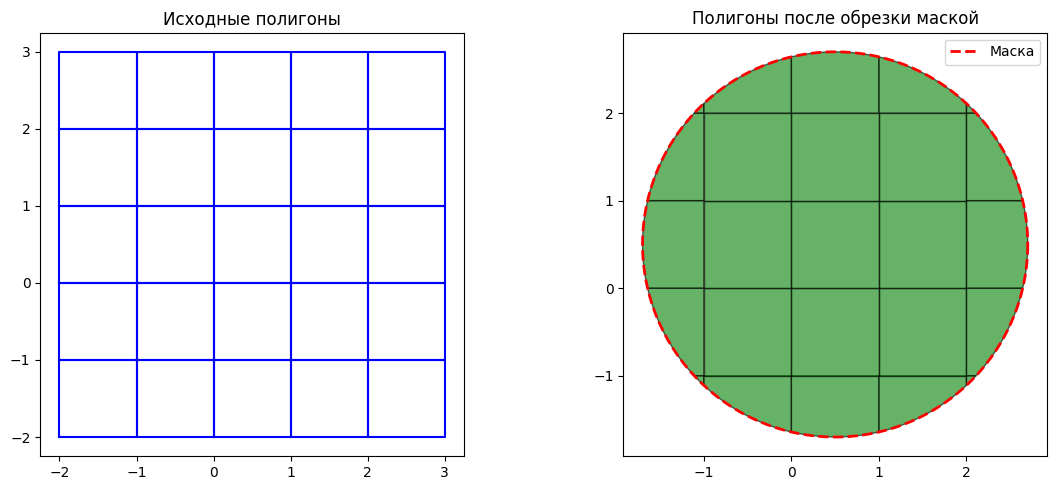

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from shapely.ops import unary_union
import matplotlib.patches as mpatches

# 1. Создаём исходные полигоны (например, сетка квадратов)
polygons = []
for i in range(-2, 3):
    for j in range(-2, 3):
        x, y = i * 1.0, j * 1.0
        poly = Polygon([(x, y), (x + 1, y), (x + 1, y + 1), (x, y + 1)])
        polygons.append(poly)

# 2. Создаём полигон-маску (например, круг, аппроксимированный полигоном)
mask_center = Point(0.5, 0.5)
mask_radius = 2.2
mask_polygon = mask_center.buffer(mask_radius, resolution=64)  # resolution — число сегментов на четверть круга

# 3. Обрезаем каждый полигон по маске
clipped_polygons = []
for poly in polygons:
    inter = poly.intersection(mask_polygon)
    if not inter.is_empty:
        # intersection может вернуть GeometryCollection, MultiPolygon и т.д.
        # Для простоты будем добавлять только Polygon и MultiPolygon
        if inter.geom_type in ['Polygon', 'MultiPolygon']:
            clipped_polygons.append(inter)

# 4. Визуализация с помощью Matplotlib
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Исходные полигоны
for poly in polygons:
    x, y = poly.exterior.xy
    ax[0].plot(x, y, 'b-')
ax[0].set_title('Исходные полигоны')
ax[0].set_aspect('equal')

# Обрезанные полигоны
for geom in clipped_polygons:
    if geom.geom_type == 'Polygon':
        x, y = geom.exterior.xy
        ax[1].fill(x, y, alpha=0.6, fc='green', ec='black')
    elif geom.geom_type == 'MultiPolygon':
        for part in geom.geoms:
            x, y = part.exterior.xy
            ax[1].fill(x, y, alpha=0.6, fc='green', ec='black')

# Нарисуем контур маски для наглядности
x_mask, y_mask = mask_polygon.exterior.xy
ax[1].plot(x_mask, y_mask, 'r--', linewidth=2, label='Маска')
ax[1].legend()
ax[1].set_title('Полигоны после обрезки маской')
ax[1].set_aspect('equal')

plt.tight_layout()
plt.show()